# Import des Netzwerks für das Modell

### Einrichtung

In [127]:
from __future__ import print_function, division
import numpy as np # 1.14.0
import pandas as pd # 0.22
import matplotlib.pyplot as plt # 2.1.2
from datetime import datetime 
import math
import dill as pickle # Transfer data for analysis # dill version 0.2.7.1

import pypsa # 0.13.1
import pypsa.geo as geo

%matplotlib inline

## Setup

Setting up all the network's main components

All of the data is taken from another thesis, written at the same chair at TU Berlin as this one. The data is provided in the form of excel-files and is read using methods from pandas.

### Variables

In [128]:
network = pypsa.Network()

In [129]:
snap_amount = 672
# tag = 96, woche = 672, monat = 2880
# snap_num = len(network.snapshots)
snap_size = 4
# snaps are given quarterly, setting this to 4 will aggregate the demand to hours

network.set_snapshots([p for p in range(snap_amount // snap_size)])

In [130]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

In [131]:
marginal_costs_carrier = {"Wind":5,
                          "ee":5,
                          "Import":100000000}

In [132]:
laendervert = [0.054, 0.074, 0.126, 0.217, 0.061, 0.075, 0.133, 0.157, 0.103]

Variables that are to be considered during unit commitment

In [133]:
added_vals = ["p_nom_min",
              "marginal_cost",
              "efficiency",
              "start_up_cost",
              "shut_down_cost",
              "min_up_time",
              "min_down_time",
              #"ramp_limit_up",
              #"ramp_limit_down"
              ]

## Data Import

In [134]:
mapGermany_file = pd.ExcelFile(cur_path + "map_cities.xlsx")
mapAbroad_file = pd.ExcelFile(cur_path + "map_countries.xlsx")
dispatch_excelFile = pd.ExcelFile(cur_path+ "DE Realisierte Erzeugung 2017.xlsx")


fleet_file = pd.read_excel(cur_path + "power_grid_mapping_generator_fleet.xlsx",
                           sheet_name="fleet_fuel", header=0, usecols="B:D")

uc_file_2017 = pd.read_excel(cur_path + "uc_data.xlsx",
                             sheet_name="2017", header=0, usecols="A:J")
#wind_file = pd.read_excel(cur_path + "Stromlast und Windeinspeisung.xlsx",
#                          sheet_name="Tabelle1", index_col=0, header=3, usecols="A:F")

demand_file = pd.read_excel(cur_path + "DE Realisierter Stromverbrauch 2017.xlsx",
                            sheet_name="mapping_demand", index_col=0, header=0, usecols="A:J")

wind_dispatch_file = pd.read_excel(dispatch_excelFile,
                                   sheet_name="mapping_wind", index_col=0, header=0, usecols="A:C")

ee_dispatch_file = pd.read_excel(dispatch_excelFile,
                                   sheet_name="ee", index_col=0, header=0, usecols="A:F")

1
2
3
4


In [135]:
dfa = demand_file.resample('H').sum()
wind_dispatch_file = wind_dispatch_file.resample('H').sum()
ee_dispatch_file = ee_dispatch_file.resample('H').sum()

### Setup within Germany

In [137]:
df_buses = pd.read_excel(mapGermany_file,
                         sheet_name="buses", header=0, usecols="B:D")
df_lines = pd.read_excel(mapGermany_file,
                         sheet_name="lines", header=0, usecols="B:D")

### Setup abroad

In [138]:
df_countries = pd.read_excel(mapAbroad_file,
                             sheet_name="buses", header=0, usecols="B:D")
df_countries_lines = pd.read_excel(mapAbroad_file,
                                   sheet_name="lines", header=0, usecols="B:D")

df_buses = df_buses.append(df_countries).reset_index(drop=True)
df_lines = df_lines.append(df_countries_lines).reset_index(drop=True)

Calculating the length of each line by using the haversine formula (needed to represent the earth's eliptical shape)

In [139]:
df_lines["length"] = 0
df_lines["x"]=0.0001
df_lines["s_nom"]= 1000000
# factor_coords_to_km = 111

for i in range(len(df_lines)):
    start = [df_buses["x"][df_lines["bus0"][i]],df_buses["y"][df_lines["bus0"][i]]]
    ende = [df_buses["x"][df_lines["bus1"][i]], df_buses["y"][df_lines["bus1"][i]]]
    # Using the haversine forumula to get distance in km
    df_lines.at[i, "length"] = geo.haversine(start, ende)

In [140]:
pypsa.io.import_components_from_dataframe(network, df_buses, "Bus")
pypsa.io.import_components_from_dataframe(network, df_lines, "Line")

Each node abroad gets a capacity of 10 GW to avoid shortages which would result in a crash of the model. Given their high price, they probably won't be used and only become interesting when it comes to future scenarios

In [141]:
#print(df_countries)

i = 9
for country in df_buses[9:17].values:
    network.add("Generator", name=("Import " + country[0]),
                bus=i,
                carrier="Import",
                p_nom=10000000000,
                marginal_cost=marginal_costs_carrier["Import"],
                committable=False)
    i += 1

## Components

### Generators

In [142]:
fleet_file.rename(columns={"fuel":"carrier",
                           "capacity[MW]":"p_nom"}, inplace=True)
fleet_file["committable"] = True

In [143]:
fleet_file["bus"] = 0

for j in range(len(fleet_file)):
    # find index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(network.buses.name) if fleet_file["state"][j] in s]
    fleet_file.at[j, "bus"] = indices[0]
    for k in range(len(added_vals)):
        # insert corresponding values according to the unit commitment file to dataframe for import
        fleet_file.at[j, added_vals[k]] = uc_file_2017[added_vals[k]][fleet_file["carrier"][j]]

In [144]:
pypsa.io.import_components_from_dataframe(network, fleet_file, "Generator")

In [145]:
# Name of each Generator is a combination of state and carrier name (e.g. "Berlin Erdgas")
gen_names = ["{0} {1}".format(s, c) for s, c in zip(fleet_file["state"], fleet_file["carrier"])]

### Wind Energy

In [146]:
p_wind_generators = [[], []]

for i in range(2):
    # grab each column from wind df
    tmp = wind_dispatch_file.iloc[:, i].tolist()
    # take datapoints corresponding to timestamps in network.snapshots
    p_wind_generators[i] = [tmp[i] for i in network.snapshots.tolist()]

The nominal power of the generators was set to one because PyPSA internally multiplies p_nom with each value from p_min_pu and p_max_pu to get the dispatched power. Setting p_nom to one offers the possibility to leave the provided data as it is (in MWh).

In [148]:
network.add("Generator", name="Offshore Nordsee",
       bus=17,
       carrier="Wind",
       p_nom=1,
       marginal_cost=marginal_costs_carrier["Wind"],
       # p_min_pu and p_max_pu have to be the same to ensure fixed amount of dispatched power
       p_min_pu=p_wind_generators[0],
       p_max_pu=p_wind_generators[0],
       committable=False)

network.add("Generator", name="Offshore Ostsee",
       bus=18,
       carrier="Wind",
       p_nom=1,
       marginal_cost=marginal_costs_carrier["Wind"],
       # p_min_pu and p_max_pu have to be the same to ensure fixed amount of dispatched power
       p_min_pu=p_wind_generators[1],
       p_max_pu=p_wind_generators[1],
       committable=False)

Attaching EE-Generation

In [150]:
p_ee_generators = [[], [], [], [], [], [], [], [], []]

for i in range(9):
    #print(i)
    tmp = ee_dispatch_file.iloc[:, 0].tolist()
    p_ee_generators[i] = [tmp[i] for i in network.snapshots.tolist()]
    network.add("Generator", name="EE-Generator {}".format(i),
           bus=i,
           carrier="ee",
           p_nom=1,
           marginal_cost=marginal_costs_carrier["ee"],
           # take datapoints corresponding to timestamps in network.snapshots
           p_min_pu=[item*laendervert[i] for item in p_ee_generators[i]],
           p_max_pu=[item*laendervert[i] for item in p_ee_generators[i]],
           committable=False)

### Attaching Loads

Convert demand to different periods if necessary

In [152]:
for i in range(9):
    demand_data_real = dfa.iloc[:, i]
    #print(i)
    network.add("Load",
           "myload{0}".format(i),
           bus=i,
           # take datapoints corresponding to timestamps in network.snapshots
           p_set=[demand_data_real[i] for i in network.snapshots.tolist()])

## Linear Optimal Power Flow (incl. unit commitment for generators)

In [153]:
network.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 9
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x33097
  Lower bound: 82462292.1396
  Upper bound: 82462292.1396
  Number of objectives: 1
  Number of constraints: 49487
  Number of variables: 33097
  Number of binary variables: 5544
  Number of integer variables: 5544
  Number of continuous variables: 27553
  Number of nonzeros: 226711
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message:

('ok', 'optimal')

## Exporting for Visualization & Analysis

## Visualization

In [154]:
gen_outs = network.generators_t.p / 1000
# No negative values for plotting
gen_outs[gen_outs < 0] = 0
power_by_carrier = gen_outs.groupby(network.generators.carrier, axis=1).sum()

In [155]:
graph_colors = {"Erdgas":"orange",
                "Braunkohle":"brown",
                "Steinkohle":"black",
                "Wind":"blue",
                "ee":"green",
                "Import":"red"}

col_order = ["Wind", "ee", "Braunkohle", "Steinkohle", "Erdgas", "Import"]
power_by_carrier = power_by_carrier[col_order]

In [156]:
# Rename columns for graph information
for i in range(len(gen_names)):
    gen_outs.rename(columns={("{}".format(i)):("{}".format(gen_names[i]))}, inplace=True)

Line graph to display the dispatched amount of energy per plant

In [157]:
network.objective

82462292.1396

Text(0,0.5,'MW')

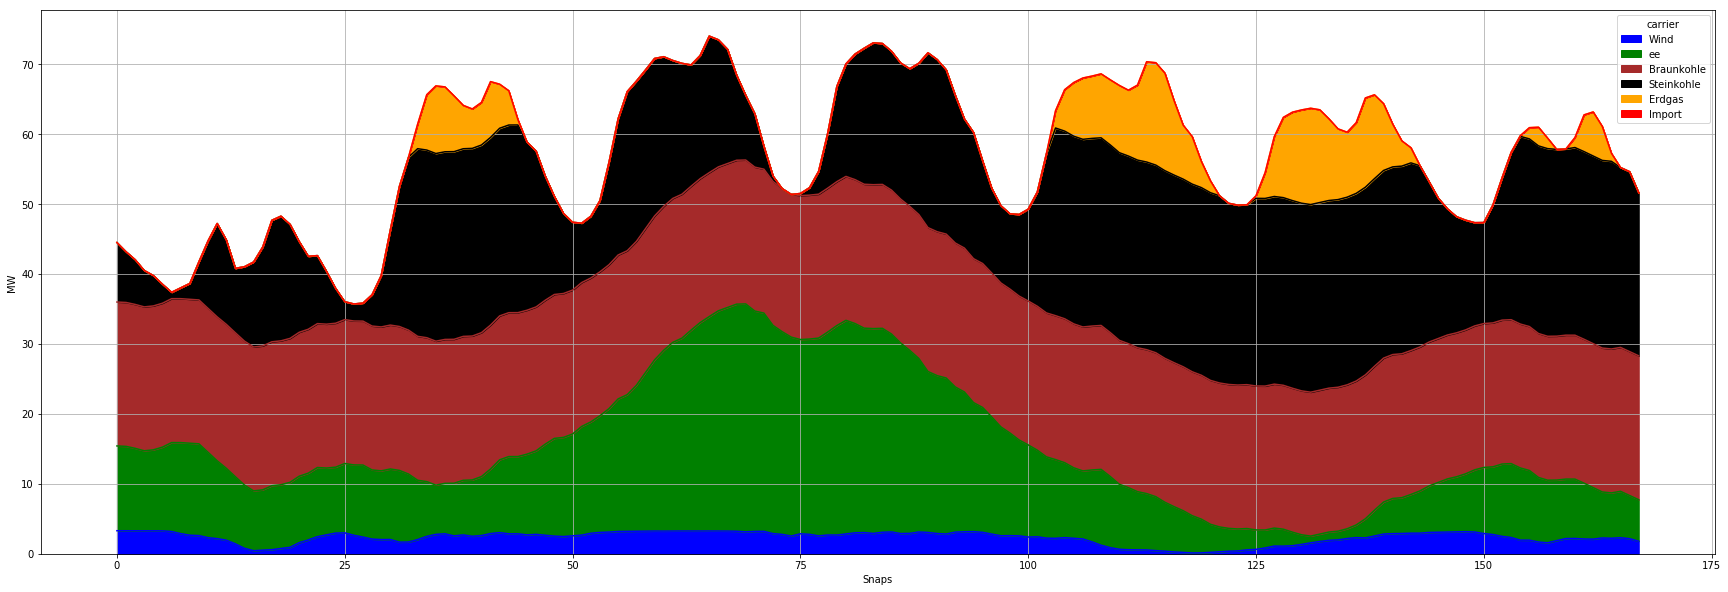

In [158]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

power_by_carrier.plot(kind="area",ax=ax, grid=True, color=[graph_colors[i] for i in power_by_carrier.columns])

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")

In [159]:
print("Hello World")

Hello World
